![](pics/header.jpg)

# April Tags

Kevin J. Walchko, Phd

10 Apr 2020

---


## References

- [April Robotics Lab](https://april.eecs.umich.edu/software/apriltag.html)
- [AprilTag: A robust and flexible visual fiducial system](https://april.eecs.umich.edu/papers/details.php?name=olson2011tags)
- isof blog: [Raspberry Pi position detection using fiducial tags](https://iosoft.blog/2019/09/02/raspberry-pi-position-detection-fiducial-tags/)
- [visual servoing](https://visp-doc.inria.fr/doxygen/visp-daily/tutorial-detection-apriltag.html)
- [Chromatags](https://austingwalters.com/chromatags/)
    - [Github: Chromatags](https://github.com/lettergram/chromatag)
- [Apriltags vs Aruco Markers](https://robotics.stackexchange.com/questions/19901/apriltag-vs-aruco-markers)

## Repos

- [AprilRobotics C/C++](https://github.com/AprilRobotics/apriltag)
- [AprilRobotics Apriltag pre-rendered images](https://github.com/AprilRobotics/apriltag-imgs)
- [pupil-labs python code](https://github.com/pupil-labs/apriltags)
- [duckietown python code](https://github.com/duckietown/dt-apriltags)
- [swatobics python code](https://github.com/swatbotics/apriltag)
- [Apriltag Tracking](https://github.com/pfrommerd/tag-tracking-matlab)

## Other Examples

- [Pose estimation](https://github.com/AprilRobotics/apriltag/issues/63)
- [C++ example](https://visp-doc.inria.fr/doxygen/visp-3.1.0/tutorial-detection-apriltag.html)
- [Draw cube on tag](https://stackoverflow.com/questions/59044973/how-do-i-draw-a-line-indicating-the-orientation-of-an-apriltag)
- [Draw chessboard pose](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_pose/py_pose.html)
- [Vehicle distance w/apriltag](https://elib.dlr.de/116211/1/Masterarbeit_PatrickIrmisch.pdf)

## PDFs

- [local](article-pdf)

In [1]:
from pupil_apriltags import Detector
from pprint import pprint

import yaml
import os
import slurm
from slurm import storage

In [2]:
import numpy as np
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

from matplotlib import pyplot as plt
import cv2
from opencv_camera import ApriltagMarker

In [5]:
# detector.nThreads = 4,        Number of threads to use
# detector.quad_decimate = 1.0, Decimate input image by this factor
# detector.quad_sigma = 0.0,    Apply low-pass blur to input; negative sharpens
# detector.refine_edges = 1,    Set to 1 to spend more time to align edges of tags
# detector.refine_decode = 0,   Set to 1 to spend more time to decode tags
# detector.refine_pose = 0,     Set to 1 to spend more time to precisely localize tags
d = Detector(families='tag36h11',
        nthreads=1,
        quad_decimate=1.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.25,
        debug=0)

# you can find the parameters inside the detector
d.params

{'families': ['tag36h11'],
 'nthreads': 1,
 'quad_decimate': 1.0,
 'quad_sigma': 0.0,
 'refine_edges': 1,
 'decode_sharpening': 0.25,
 'debug': 0}

# Determining the Orientation [Not working]

In [35]:
# read in the camera and test setup info
yml = storage.read("test_info.yaml")
pprint(yml)

{'multiple_tags_test': {'K': [338.563277422543,
                              0.0,
                              336.45495347495824,
                              0.0,
                              338.939280638548,
                              230.486982216255,
                              0.0,
                              0.0,
                              1.0],
                        'files': ['test_image_multiple_01.png',
                                  'test_image_multiple_02.png',
                                  'test_image_multiple_03.png',
                                  'test_image_multiple_04.png',
                                  'test_image_multiple_05.png',
                                  'test_image_multiple_06.png',
                                  'test_image_multiple_07.png',
                                  'test_image_multiple_08.png',
                                  'test_image_multiple_09.png',
                                  'test_image_multiple

In [60]:
imgs = []
angles = {}
files = yml['rotation_test']['files']
for i, f in enumerate(files):
    im = cv2.imread("test_files/" + f,0)
    imgs.append(im)
    
    b=os.path.basename(files[i]).split('.')[0]
    a = int(b.split('_')[-1])
    angles[i] = a
    
print(f">> found {len(imgs)} image")

>> found 15 image


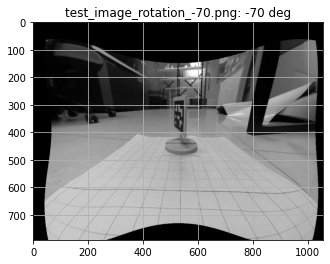

In [77]:
i=14
plt.imshow(imgs[i], cmap="gray")
plt.grid(True)
plt.title(os.path.basename(f"{files[i]}: {angles[i]} deg"));

In [78]:
K = yml['rotation_test']['K']
tag_size = yml['rotation_test']['tag_size']

params = [K[0],K[2],K[4],K[5]]
print(params)

# To get pose:
#     estimate_tag_pose = True
#     camera_params = [fx, fy, cx, cy]
#     tag_size = float (in meters)
tags = d.detect(imgs[i], 
                estimate_tag_pose=True, 
                camera_params=params, 
                tag_size=tag_size)
print(f"Tags found: {len(tags)}")
print(tags)

[329.8729619143081, 528.0, 332.94611303946357, 396.0]
Tags found: 1
[Detection object:
tag_family = b'tag36h11'
tag_id = 76
hamming = 0
decision_margin = 42.0277099609375
homography = [[-59.9  17.3 529.3]
 [-42.7  63.5 339.6]
 [ -0.1   0.    1. ]]
center = [529.3 339.6]
corners = [[514.9 378.5]
 [547.3 405.3]
 [549.9 283.9]
 [514.9 287. ]]
pose_R = [[-0.1  0.1 -1. ]
 [ 0.2  1.   0.1]
 [-1.   0.2  0.1]]
pose_t = [[ 0.2]
 [-0. ]
 [ 0.3]]
pose_err = 8.649423048468948e-06
]


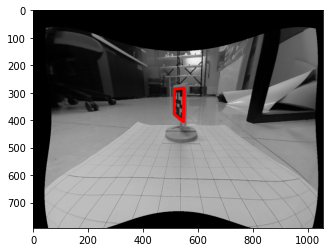

In [79]:
pts = tags[0].corners
pts = pts.reshape((-1,1,2)).astype('int32')

c = cv2.cvtColor(imgs[i],cv2.COLOR_GRAY2RGB)

cv2.polylines(c,[pts],True,(255,0,0),10)
plt.imshow(c);

In [80]:
r = tags[0].pose_R
print(r)

[[-0.1  0.1 -1. ]
 [ 0.2  1.   0.1]
 [-1.   0.2  0.1]]


In [81]:
from math import atan2, asin, pi
r2d = 180/pi

roll = atan2(r[2,1],r[2,2])*r2d
pitch = -asin(r[2,0])*r2d
yaw = atan2(r[1,0],r[0,0])*r2d

# this doesn't look right??
print(roll, pitch, yaw)

64.30693908602105 76.41738239666776 109.8414783145883


In [92]:
def rpy(r):
    r2d = 180/pi
    roll = atan2(r[2,1],r[2,2])*r2d
    pitch = -asin(r[2,0])*r2d
    yaw = atan2(r[1,0],r[0,0])*r2d
    return roll, pitch, yaw